In [2]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# specify the file name to open..!!
filename = '1_3.jpg'

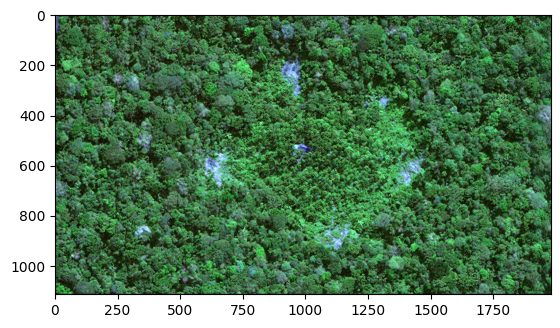

In [4]:
# loading the image - let's take a look at it
image = cv2.imread(filename)
plt.imshow(image)

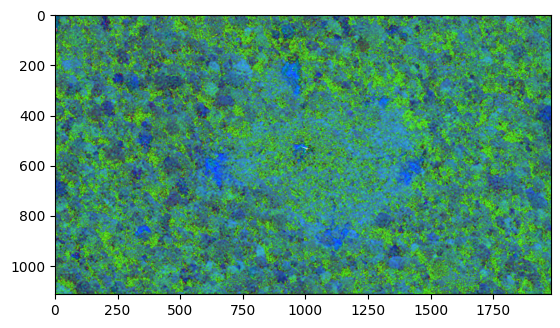

In [5]:
# converting the image to hsv color channel - V channel will be useful for us..!!
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image, cmap='hsv')

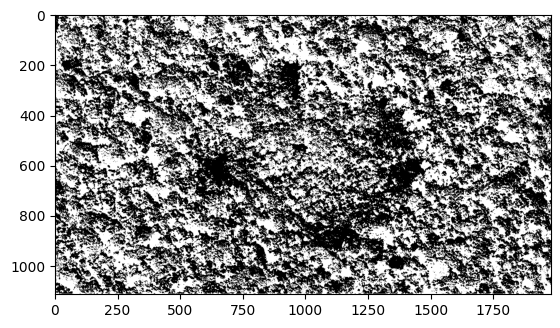

In [6]:
# Thresholding the imahge in range 120 - 210 with OTSU
threshold, binary_image = cv2.threshold(hsv_image[:, :, 2], 120, 210, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(binary_image, cmap='binary')

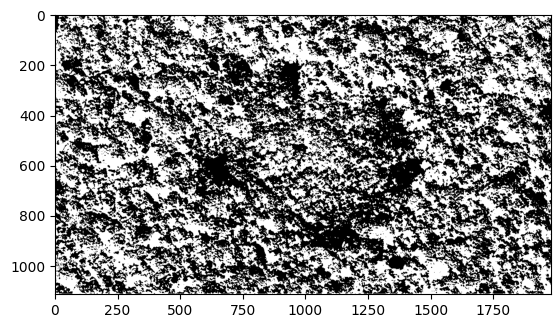

In [7]:
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt

# Assuming binary_image is your input binary image
# Apply median filter without selem parameter
image_denoised = filters.median(binary_image)

# Display the denoised image
plt.imshow(image_denoised, cmap='binary')
plt.show()


In [8]:
binary_image = image_denoised

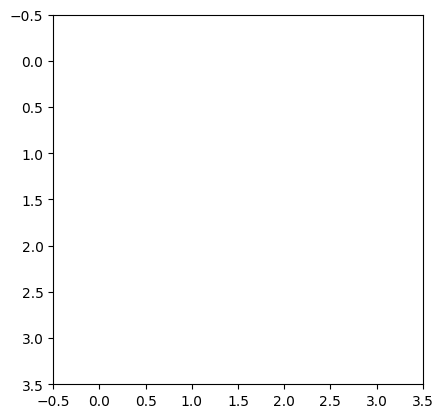

In [9]:
# Let's make a kernal of 4x4 for mainpulating the image
kernel = np.ones((4, 4), dtype='uint8')
plt.imshow(kernel, cmap='binary')

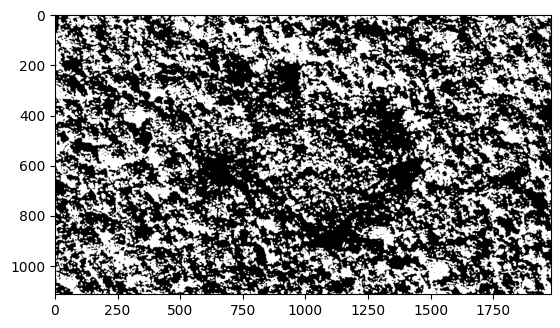

In [10]:
# with the kernal we can do morphological closing to make the regions of interests - trees more dominant
morph_closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
plt.imshow(morph_closed_image, cmap='binary')

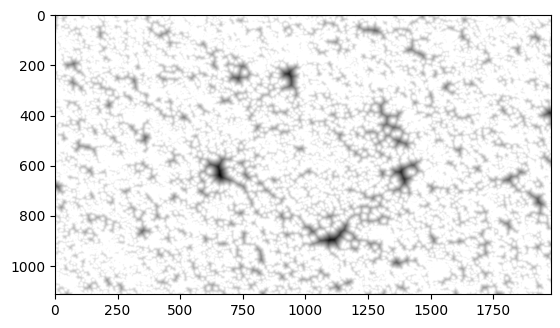

In [11]:
# let's go for distance transfrom 

dist_transform_image = cv2.distanceTransform(morph_closed_image, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
plt.imshow(dist_transform_image, cmap='binary')

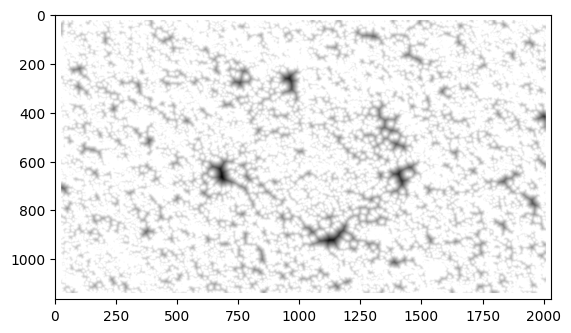

In [12]:
# let's give some padding to the image so that further kernal operations will be easy..!

border_size = 25
dist_border = cv2.copyMakeBorder(dist_transform_image, border_size, border_size, border_size, border_size, 
                                cv2.BORDER_CONSTANT | cv2.BORDER_ISOLATED, 0)
plt.imshow(dist_border, cmap='binary')

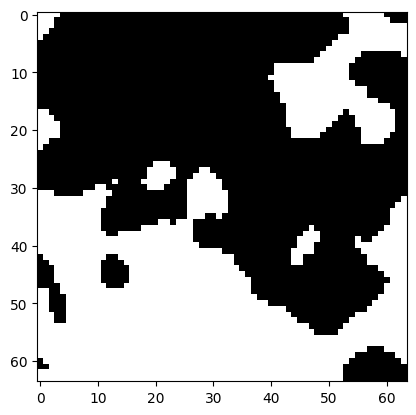

In [13]:
import cv2
from skimage import filters
import matplotlib.pyplot as plt

gap = 8

template_file = cv2.imread('template1.jpg')
template_file = cv2.resize(template_file, (64, 64))
template_file = cv2.cvtColor(template_file, cv2.COLOR_BGR2HSV)

_, thresholded_image = cv2.threshold(template_file[:, :, 2], 120, 210, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Apply median filter using cv2.medianBlur
image_denoised = cv2.medianBlur(thresholded_image, 5)  # Adjust the kernel size as needed

plt.imshow(image_denoised, cmap='binary')
plt.show()


In [14]:
kernel2 = image_denoised

In [15]:
# for the opencv to consider the kernal template we made it must be a binary image with 0 and 1
# let's convert the pixel values to 0's and 1's - ofcourse there are better methods :D

for i in range(len(kernel2)):
    for j in range(len(kernel2[i])):
        if kernel2[i][j] != 0:
            kernel2[i][j] = 1

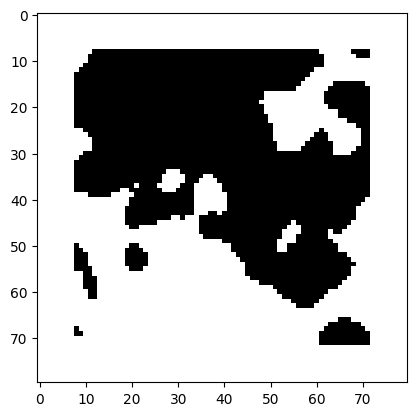

In [16]:
# let's give some padding to our template - chosen after some trial and error.!!
kernel2 = cv2.copyMakeBorder(kernel2, gap, gap, gap, gap, cv2.BORDER_CONSTANT | cv2.BORDER_ISOLATED, 0)
plt.imshow(kernel2, cmap='binary')

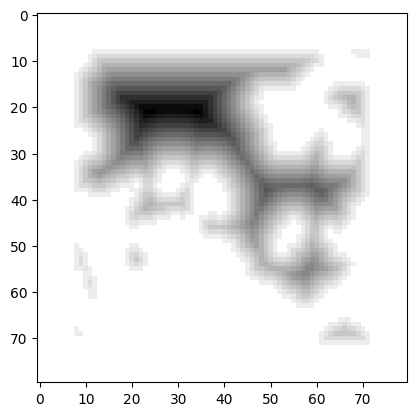

In [17]:
# let's now apply distance transform on the template..!!
dist_trans_template = cv2.distanceTransform(kernel2, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
plt.imshow(dist_trans_template, cmap='binary')

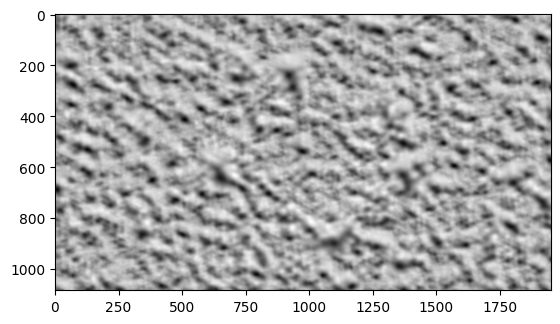

In [18]:
# Finally, now we can try to match our template - not on the actual image but on the outputs of distance transforms
# simply because it is working better.!!
template_matched = cv2.matchTemplate(dist_border, dist_trans_template, cv2.TM_CCOEFF_NORMED)
plt.imshow(template_matched, cmap='binary')

In [19]:
mn, mx, _, _ = cv2.minMaxLoc(template_matched)
th, peaks = cv2.threshold(template_matched, 0.10, 0.60, cv2.THRESH_BINARY)

# let's go for the peak value in the template matched image..!
peaks8u = cv2.convertScaleAbs(peaks)

# find the contours in the peaks
contours, hierarchy = cv2.findContours(peaks8u, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Optionally, you can convert peaks8u again if needed
peaks8u = cv2.convertScaleAbs(peaks)


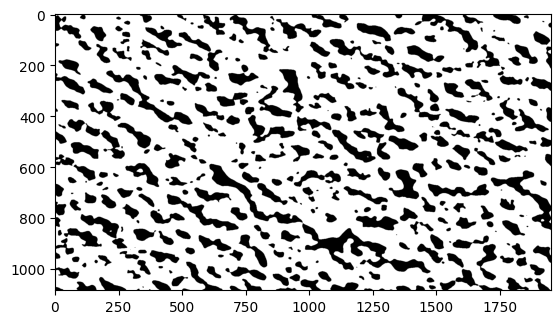

In [20]:
plt.imshow(peaks8u, cmap='binary')

In [21]:
copy = cv2.imread(filename)

Number of trees :  289


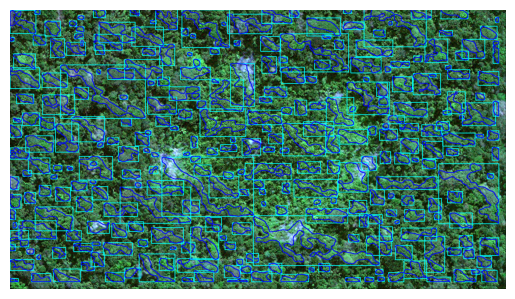

In [22]:
# Now let's count the contouurs - the trees.!!

count = 0

for i in range(len(contours)):
    
    if cv2.contourArea(contours[i]) < 150:
        continue
        
    x, y, w, h = cv2.boundingRect(contours[i])    

    cv2.rectangle(copy, (x, y), (x+w, y+h), (0, 255, 255), 2)
    cv2.drawContours(copy, contours, i, (0, 0, 255), 2)
    
    count += 1

print('Number of trees : ', count)

# also let's see how the countours are selected by plotting countours on the actual image.!!
plt.axis('off')
plt.imshow(copy)

Number of green coverages:  267


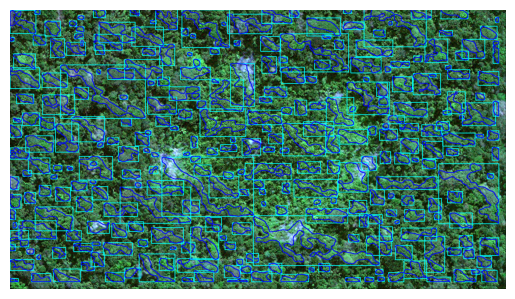

In [24]:
# Convert the image to HSV color space
hsv_image = cv2.cvtColor(copy, cv2.COLOR_BGR2HSV)

# Define the range for green color in HSV
lower_green = (36, 25, 25)
upper_green = (86, 255, 255)

# Create a mask to isolate green areas
green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Find contours in the green mask
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

total_green_coverages = 0

for i in range(len(contours)):
    if cv2.contourArea(contours[i]) < 150:
        continue
    
    # Get the bounding box for the contour
    x, y, w, h = cv2.boundingRect(contours[i])
    
    # Draw rectangle and contours
    cv2.rectangle(copy, (x, y), (x+w, y+h), (0, 255, 255), 2)
    cv2.drawContours(copy, contours, i, (0, 0, 255), 2)
    
    # Count green coverages within the contour
    green_coverage_count = 0
    for gc in green_contours:
        if cv2.pointPolygonTest(gc, (x + w//2, y + h//2), False) == 1:  # Check if the center of the bounding box is inside the green contour
            green_coverage_count += 1
    
    total_green_coverages += green_coverage_count

# Print the total number of green coverages
print('Number of green coverages: ', total_green_coverages)

# Plot the image with contours
plt.axis('off')
plt.imshow(copy)


In [6]:
!pip install deepforest 


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from deepforest import main
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

ModuleNotFoundError: No module named 'deepforest'